In [26]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.0 MB/s eta 0:00:00


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
electric_df = pd.read_csv('/content/Electric_Production.csv')

In [4]:
electric_df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [5]:
electric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [6]:
electric_df['DATE'] = pd.to_datetime(electric_df['DATE'])

In [7]:
electric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        397 non-null    datetime64[ns]
 1   IPG2211A2N  397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


In [8]:
electric_df = electric_df.set_index('DATE')

In [9]:
electric_df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [10]:
electric_df.isna().sum()

,0
IPG2211A2N,0


Text(0.5, 1.0, 'Electric Production')

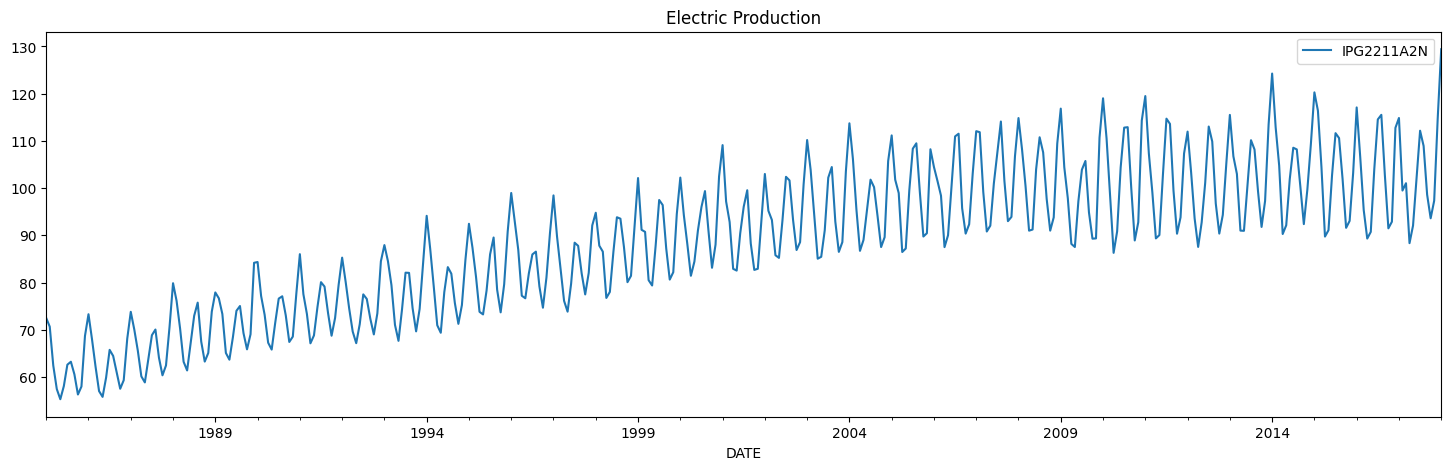

In [11]:
electric_df.plot(figsize=(18, 5))
plt.title('Electric Production')


In [15]:
def adf_test(data):
  result = adfuller(data)
  print(f'ADF Statistics:{result[0]}')
  print(f'p-value: {result[1]}')
  if result[1] <= 0.05:
    print('Reject null hypothesis - Data is Stationary')
  else:
    print('Accept null hypothesis - Data is not Stationary')

In [16]:
adf_test(electric_df['IPG2211A2N'])

ADF Statistics:-2.256990350047235
p-value: 0.1862146911658712
Accept null hypothesis - Data is not Stationary


In [17]:
electric_df['Order_12'] = electric_df['IPG2211A2N'] - electric_df['IPG2211A2N'].shift(12)

In [18]:
electric_df.head()

,IPG2211A2N,Order_12
DATE,,
1985-01-01,72.5052,NaN
1985-02-01,70.6720,NaN
1985-03-01,62.4502,NaN
1985-04-01,57.4714,NaN
1985-05-01,55.3151,NaN


In [19]:
adf_test(electric_df['Order_12'].dropna())

ADF Statistics:-5.673482023381762
p-value: 8.812644938088861e-07
Reject null hypothesis - Data is Stationary


Text(0.5, 1.0, 'Electric Production after Stationary Transition of Data')

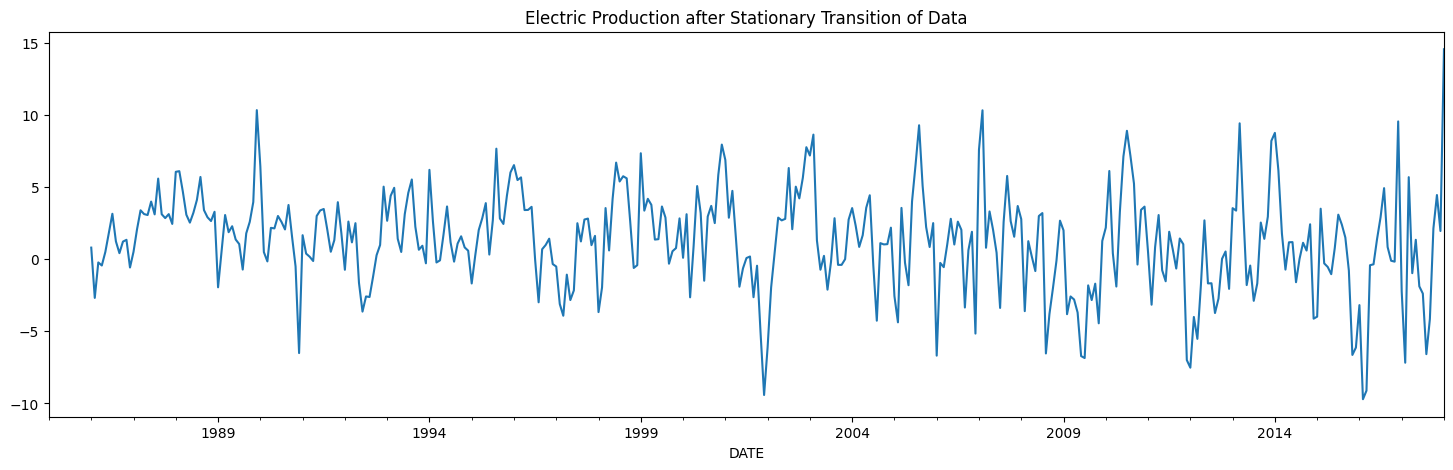

In [20]:
electric_df['Order_12'].plot(figsize=(18, 5))
plt.title('Electric Production after Stationary Transition of Data')

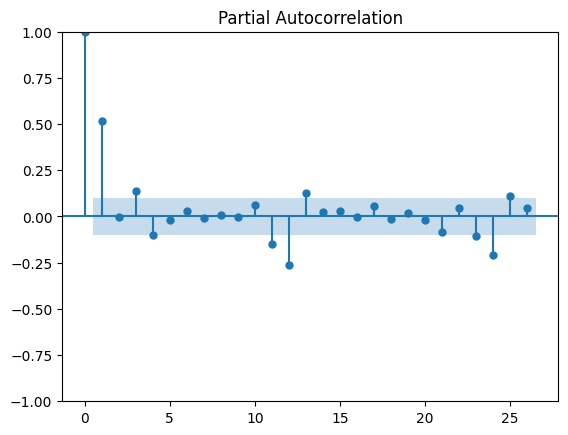

In [22]:
pacf = plot_pacf(electric_df['Order_12'].dropna())

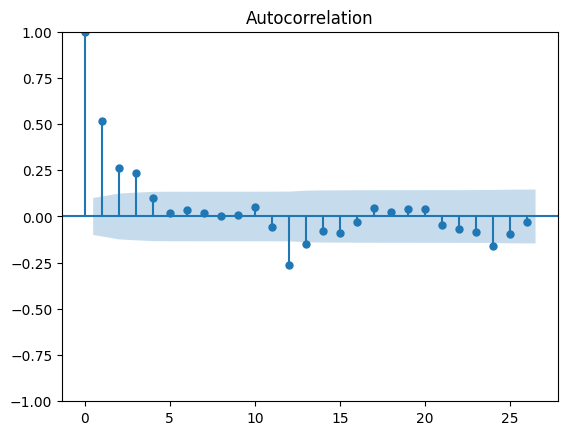

In [23]:
acf = plot_acf(electric_df['Order_12'].dropna())

In [24]:
train_df = electric_df[:315]
test_df = electric_df[315:]

In [28]:
stepwise_fit = auto_arima(train_df['IPG2211A2N'] , seasonal=True , m=12)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

In [29]:
print(stepwise_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  315
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -670.152
Date:                              Sun, 02 Mar 2025   AIC                           1352.305
Time:                                      01:15:03   BIC                           1374.587
Sample:                                  01-01-1985   HQIC                          1361.219
                                       - 03-01-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1188      0.069      1.729      0.084      -0.016       0.254
ar.L1          0.92

In [31]:
model = SARIMAX(train_df['IPG2211A2N'] , order=stepwise_fit.order , seasonal_order=stepwise_fit.seasonal_order)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [32]:
fitted_model = model.fit(disp = False)

In [33]:
print(fitted_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           IPG2211A2N   No. Observations:                  315
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -673.350
Date:                              Sun, 02 Mar 2025   AIC                           1356.700
Time:                                      01:19:40   BIC                           1375.268
Sample:                                  01-01-1985   HQIC                          1364.129
                                       - 03-01-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9981      0.003    345.426      0.000       0.992       1.004
ma.L1         -0.41

In [34]:
test_df.head()

,IPG2211A2N,Order_12
DATE,,
2011-04-01,89.3583,3.0583
2011-05-01,90.0698,-0.7666
2011-06-01,102.8204,-1.5334
2011-07-01,114.7068,1.9002
2011-08-01,113.5958,0.6944


In [37]:
pred = fitted_model.predict(start = test_df.index[0],end =test_df.index[-1])

In [38]:
pred

,predicted_mean
2011-04-01,90.159333
2011-05-01,92.056593
2011-06-01,102.981221
2011-07-01,110.711943
2011-08-01,111.491746
...,...
2017-09-01,104.232073
2017-10-01,96.293137
2017-11-01,98.374603
2017-12-01,115.973529


In [39]:
test_df['Sarimax_pred'] = pred

<ipython-input-39-a99a0c85b4c5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Sarimax_pred'] = pred


In [40]:
test_df.head()

,IPG2211A2N,Order_12,Sarimax_pred
DATE,,,
2011-04-01,89.3583,3.0583,90.159333
2011-05-01,90.0698,-0.7666,92.056593
2011-06-01,102.8204,-1.5334,102.981221
2011-07-01,114.7068,1.9002,110.711943
2011-08-01,113.5958,0.6944,111.491746


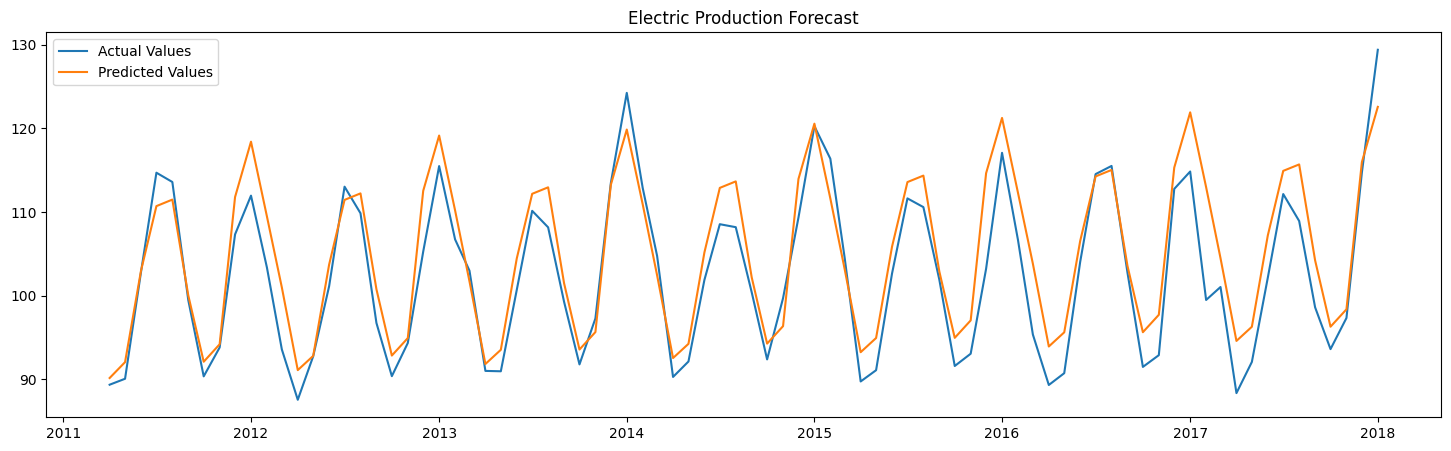

In [45]:
plt.figure(figsize=(18, 5))
plt.title('Electric Production Forecast')
plt.plot(test_df.index, test_df['IPG2211A2N'], label='Actual Values')
plt.plot(test_df.index, test_df['Sarimax_pred'], label='Predicted Values')
plt.legend()
plt.show()  # Ensure the plot is displayed
